## Contextualized model

Let's check where the context really helps

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)


In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

context_model_name = "../models/bert-contextualized-hate-speech-es/"
no_context_model_name = "../models/bert-non-contextualized-hate-speech-es"
full_context_model_name = "../models/bert-title-body-hate-speech-es/"


context_model = AutoModelForSequenceClassification.from_pretrained(context_model_name, return_dict=True, num_labels=2)
no_context_model = AutoModelForSequenceClassification.from_pretrained(no_context_model_name, return_dict=True, num_labels=2)
full_context_model = AutoModelForSequenceClassification.from_pretrained(no_context_model_name, return_dict=True, num_labels=2)

context_model.eval()
no_context_model.eval()
full_context_model.eval()


device = "cuda" if torch.cuda.is_available() else "cpu"

context_model = context_model.to(device)
no_context_model = no_context_model.to(device)
full_context_model = full_context_model.to(device)
# Tienen mismo tokenizer así que todo bien

no_context_tokenizer = AutoTokenizer.from_pretrained(no_context_model_name)
context_tokenizer = AutoTokenizer.from_pretrained(context_model_name)
full_context_tokenizer = AutoTokenizer.from_pretrained(context_model_name)

no_context_tokenizer.model_max_length = 128
context_tokenizer.model_max_length = 256

In [9]:
from hatedetection.training import tokenize

batch_size = 32
eval_batch_size = 16

dataset = test_dataset


no_context_dataset = dataset.map(lambda x: tokenize(no_context_tokenizer, x, context='none'), batched=True, batch_size=eval_batch_size)
context_dataset = dataset.map(lambda x: tokenize(context_tokenizer, x, context='title'), batched=True, batch_size=eval_batch_size)
full_context_dataset = dataset.map(lambda x: tokenize(full_context_tokenizer, x, context='title+body'), batched=True, batch_size=eval_batch_size)


In [10]:

def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': examples['HATEFUL']})
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

no_context_dataset = format_dataset(no_context_dataset)
context_dataset = format_dataset(context_dataset)
full_context_dataset = format_dataset(full_context_dataset)


Lo cargamos sólo para evaluar 🤗

In [11]:
from hatedetection.metrics import compute_hate_metrics
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=".",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
)


context_trainer = Trainer(
    model=context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)

full_context_trainer = Trainer(
    model=full_context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)

no_context_trainer = Trainer(
    model=no_context_model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
)


## Resultados

In [12]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)


df_full_context_results = pd.DataFrame([full_context_trainer.evaluate(full_context_dataset)])
df_context_results = pd.DataFrame([context_trainer.evaluate(context_dataset)])
df_no_context_results = pd.DataFrame([no_context_trainer.evaluate(no_context_dataset)])


In [ ]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

## Dev Results

In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

,eval_loss,eval_accuracy,eval_f1,eval_macro_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,init_mem_cpu_alloc_delta,init_mem_gpu_alloc_delta,init_mem_cpu_peaked_delta,init_mem_gpu_peaked_delta,eval_mem_cpu_alloc_delta,eval_mem_gpu_alloc_delta,eval_mem_cpu_peaked_delta,eval_mem_gpu_peaked_delta
index,,,,,,,,,,,,,,,,
No context,0.50128,0.90753,0.66980,0.80802,0.73431,0.61572,38.45080,236.82200,43460,0,18258,0,200737,0,755193,69447680
Title,0.60040,0.92554,0.73883,0.84771,0.79322,0.69142,76.05850,119.72400,52465,0,18258,0,209357,0,756777,189042688
Title and Body,0.85207,0.86130,0.18778,0.55598,0.86905,0.10526,156.20100,58.29700,43325,0,18258,0,430762,0,742281,579227648


In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

,eval_loss,eval_accuracy,eval_f1,eval_macro_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,init_mem_cpu_alloc_delta,init_mem_gpu_alloc_delta,init_mem_cpu_peaked_delta,init_mem_gpu_peaked_delta,eval_mem_cpu_alloc_delta,eval_mem_gpu_alloc_delta,eval_mem_cpu_peaked_delta,eval_mem_gpu_peaked_delta
index,,,,,,,,,,,,,,,,
No context,0.55797,0.90655,0.67655,0.81097,0.71543,0.64167,38.28570,237.84300,44493,0,18258,0,198682,0,754465,69447680
Title,0.59812,0.92335,0.73174,0.84351,0.78354,0.68637,75.95080,119.89300,55218,0,18258,0,213028,0,756649,189042688
Title and Body,0.81184,0.86448,0.26722,0.59628,0.75758,0.16222,156.60900,58.14500,44358,0,18258,0,428073,0,742209,579227648


In [8]:
df_results = pd.concat([df_no_context_results, df_context_results, df_full_context_results])
df_results["index"] = ["No context", "Title", "Title and Body"]
df_results.set_index("index")

,eval_loss,eval_accuracy,eval_f1,eval_macro_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,init_mem_cpu_alloc_delta,init_mem_gpu_alloc_delta,init_mem_cpu_peaked_delta,init_mem_gpu_peaked_delta,eval_mem_cpu_alloc_delta,eval_mem_gpu_alloc_delta,eval_mem_cpu_peaked_delta,eval_mem_gpu_peaked_delta
index,,,,,,,,,,,,,,,,
No context,0.55797,0.90655,0.67655,0.81097,0.71543,0.64167,37.81200,240.82300,44493,0,18258,0,196610,0,756169,69447680
Title,0.59812,0.92335,0.73174,0.84351,0.78354,0.68637,68.17460,133.56900,55162,0,18258,0,427754,0,742337,189042688
Title and Body,0.81184,0.86448,0.26722,0.59628,0.75758,0.16222,162.51570,56.03100,44358,0,18258,0,211508,0,756361,579227648


## Error Analysis

In [11]:
context_prediction = context_trainer.predict(context_dataset)
no_context_prediction = no_context_trainer.predict(no_context_dataset)

In [12]:
context_prediction.predictions.argmax(axis=1).shape

(9106,)

In [13]:
df = context_dataset.to_pandas()
df.drop(["token_type_ids", "attention_mask"], axis=1, inplace=True)


df["context_pred"] = context_prediction.predictions.argmax(axis=1)
df["no_context_pred"] = no_context_prediction.predictions.argmax(axis=1)

df.set_index("id", inplace=True)

df

,APPEARANCE,CALLS,CLASS,CRIMINAL,DISABLED,HATEFUL,LGBTI,POLITICS,RACISM,WOMEN,input_ids,labels,text,title,context_pred,no_context_pred
id,,,,,,,,,,,,,,,,
337647,0,0,0,0,0,0,0,0,0,0,"[4, 1005, 30966, 5021, 4792, 1039, 1346, 1009,...",0,[USER] Que cinismo,Wuhan celebra el fin de la cuarentena por el c...,0,0
336499,0,0,0,0,0,0,0,0,0,0,"[4, 20828, 16527, 13397, 995, 1100, 2926, 2150...",0,[USER] La sociedad les dio la espalda en 2019 ...,"Patricia Bullrich: ""Somos mirados por la socie...",0,0
387046,0,0,0,0,0,0,0,0,0,0,"[4, 1120, 1507, 30966, 14319, 30957, 1057, 126...",0,"[USER] Revolucionario ponerse en bolas? Uy sí,...",¡Calu Rivero se desnudó para Instagram!,0,0
350341,0,0,0,0,0,0,0,0,0,0,"[4, 1039, 4537, 2038, 6371, 1053, 5168, 1081, ...",0,[USER] Como??..si deberia estar en la CARCEL c...,El líder piquetero Luis DElía pidió el indulto...,0,0
336008,0,0,0,0,0,0,0,0,0,0,"[4, 15885, 29559, 3568, 1054, 26487, 1431, 995...",0,[USER] Seamos serios si en la Pcia de Cornejo ...,Cristina Kirchner no afloja: le pegó a Horacio...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331427,0,0,0,0,0,0,0,0,0,0,"[4, 8695, 1600, 1098, 998, 30956, 1008, 3547, ...",0,[USER] Este pibe no puede más de pelotudo!!! L...,Banderazo 17A. Juan Grabois pidió multas para ...,0,0
355482,0,0,0,0,0,0,0,0,0,0,"[4, 1039, 24564, 8815, 4202, 1009, 19948, 1137...",0,"[USER] No es un mensaje, todo hay que explicar...",El contundente mensaje de Noelia Marzol sobre ...,0,0
400833,0,0,0,0,0,0,0,0,0,0,"[4, 1724, 1048, 1389, 1328, 1097, 1041, 5047, ...",0,"[USER] Perón, Perón, que grande sos",Acuerdo con Putin para que Rusia instale una b...,0,0


In [14]:
sum(df["context_pred"] != df["no_context_pred"])

643

Hagamos un barplot de la performance de la detección para cada categoría

- Para categoría C, me fijo la recall de cada clasificador en esa categoría

Ojo que es distinto que la tarea de categorización



In [16]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 400

df[(df["DISABLED"] != 0) & (df["no_context_pred"] == 0)][["title", "text", "no_context_pred", "context_pred", "labels", "DISABLED"]]

,title,text,no_context_pred,context_pred,labels,DISABLED
id,,,,,,
333926,"Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte",[USER] Nefasta porrera!,0,0,1,1
362143,Un grupo de encapuchados saqueó una tienda de Louis Vuitton en Portland en medio de las protestas por la muerte de George Floyd,[USER] No digas que la Psicótica mando a los muchachos de Puerto Madero. Increíble.,0,0,1,1
377207,"Eduardo Duhalde: ""Mi impresión es que Alberto Fernández está grogui, como De la Rúa""",[USER] Este tipo tiene demencia cenil!!,0,0,1,1
384261,"Carrió dice que el gobierno usa la pandemia para ""establecer un estado de sitio""",[USER] abandonó el tratamiento psiquiátrico. Es obvio,0,0,1,1
394030,"Nicolás Kreplak: ""Algún sector de clase alta es muy reticente a seguir las normativas""","[USER] exacto, los que estaban hoy revoleando basura en tribunales o en el velorio del falopero de maradona eran clase altísima...",0,0,1,1
384257,"Carrió dice que el gobierno usa la pandemia para ""establecer un estado de sitio""",[USER] abandonó el tratamiento psiquiátrico. Es obvio,0,0,1,1
371393,"Claribel Medina, enojada con un grupo de gente reunida en un bar: ""¿Por qué para unos sí y para otros no?""",[USER] B O R R A C H A\nB U C H O N A,0,0,1,1
332353,"El mensaje de Florencia Kirchner antes de volver a la Argentina: ""Tengo lágrimas negras""",[USER] Ya está curada la nena?? No tomas más Falopa??,0,1,1,1
330665,"En pandemia, Mayra Mendoza desplegó una colección de ""barbijos militantes""","[USER] Chupe! Vamos! Pero chupe fuerte que para eso les pagan.\n\nAhhh y el hecho de que nos pasaron un mapa de Quilmes en rojo a los que trabajamos ahí y la advertencia de que no fuéramos a las escuelas, eso no lo lei",0,0,1,1


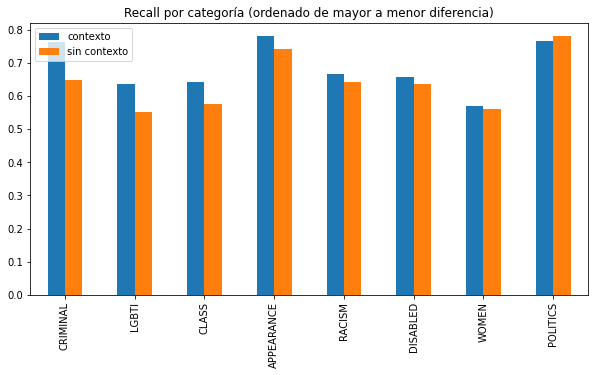

In [17]:
from hatedetection import extended_hate_categories, hate_categories
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

df_cat_score = pd.DataFrame()

for category in hate_categories:
    cat_df = df[df[category] > 0]
    # Son todos 1s
    labels = cat_df["labels"]
    context_score = recall_score(labels, cat_df["context_pred"])
    no_context_score = recall_score(labels, cat_df["no_context_pred"])
    
    df_cat_score.loc[category, "contexto"] = context_score
    df_cat_score.loc[category, "sin contexto"] = no_context_score


# Ordenamos por diff
df_cat_score["diff"] = df_cat_score["contexto"] - df_cat_score["sin contexto"]
df_cat_score = df_cat_score.sort_values("diff", ascending=False)


df_cat_score.loc[:, ["contexto", "sin contexto"]].plot(kind="bar", title="Recall por categoría (ordenado de mayor a menor diferencia)", figsize=(10, 5))

plt.savefig("recall_category.png")

In [85]:
df_cat_score

,contexto,sin contexto,diff
CRIMINAL,0.79200,0.61600,0.17600
LGBTI,0.68939,0.59091,0.09848
CLASS,0.63636,0.55303,0.08333
RACISM,0.68246,0.61848,0.06398
APPEARANCE,0.77778,0.72963,0.04815
WOMEN,0.56221,0.52535,0.03687
DISABLED,0.65882,0.62353,0.03529
POLITICS,0.74439,0.75336,-0.00897


<AxesSubplot:title={'center':'Recall por categoría (ordenado de mayor a menor diferencia)'}>

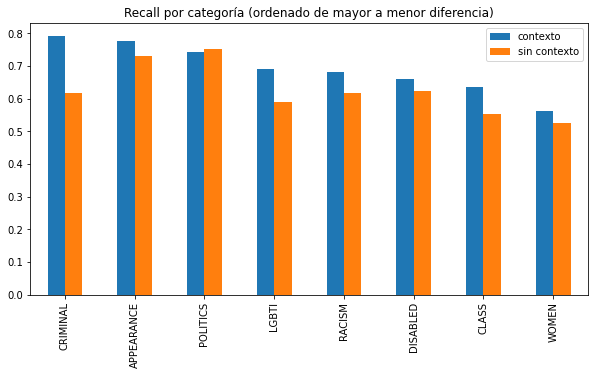

In [92]:
df_cat_score.loc[:, ["contexto", "sin contexto"]].sort_values("contexto", ascending=False).plot(
    kind="bar", title="Recall por categoría (ordenado de mayor a menor diferencia)", figsize=(10, 5),
)

## On hateful messages

In [20]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 300

mismatches = df[df["context_pred"] != df["no_context_pred"]]

hateful = mismatches[mismatches["labels"] > 0]

not_hateful = mismatches[mismatches["labels"] == 0]

hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("no_context_pred", ascending=False)

,context,text,context_pred,no_context_pred,labels
id,,,,,
371545,Ernestina Pais no se dio cuenta de que estaba en cámara e insultó a Ceferino Reato,"[USER] un azko de kakas y si es de América 2 ,si es kaka matones",0,1,1
400793,Histórico: Mara Gómez fue habilitada y será la primera jugadora trans en el fútbol argentino,[USER] Va a tener mucha ventaja a favor por correr con 3 piernas,0,1,1
393930,"Pablo Duggan se casó con Karen, su novia venezolana: ""Estoy muy feliz de haberla conocido, me cambió la vida""","[USER] Novio venezolano,es un trabuco, digan la verdad.",0,1,1
391462,Científicos argentinos señalaron que es casi imposible que carne exportada a China llegue a destino con coronavirus,"[USER] -Eso lo dicen los chinos para rebajar el precio, como en todo, son unos hdp.",0,1,1
375446,"La declaración de un testigo del caso del jubilado que mató a un ladrón: ""Levantaba la mano pidiendo ayuda y el hombre le volvió a disparar""","[USER] El jubilado no sólo fue asaltado sino que fue golpeado salvajemente por los delincuentes. Ni me quiero imaginar el dolor, el miedo y el shock en el que estaba ese hombre. Me importa un bled...",0,1,1
341105,"Un asesor de Donald Trump acusó a China de usar viajeros para propagar el coronavirus: ""Los enviaron en aviones a Milán, Nueva York y alrededor del mundo""","[USER] Aquí seguro vinieron los chinitos trayendo la plaga, fue después del año nuevo chino, regresaron con todos los parásitos.",0,1,1
367467,Los pesqueros chinos están poniendo en riesgo la supervivencia de diversas especies animales en las islas Galápagos,[USER] Siempre los chinos metidos en cada quilombo posible ... son como langostas ...,0,1,1
378823,"""¿Qué es un look Plus Size? ¿El nuevo eufemismo para decir 'gorda'?""","[USER] A ber, que problema hay en decirle pelado a un pelado, gorda a una gorda o macrista a un boludo?",0,1,1
364203,"Diego Maradona les responde a sus hijas: ""Dalma y Gianinna eligieron estar con quien no es un buen ejemplo de madre""","[USER] Jjaja, idiota, él será mejor ejemplo, maracoca",0,1,1


In [27]:
lgbti_hateful = hateful[hateful["LGBTI"] > 0]

lgbti_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("context_pred")

,context,text,context_pred,no_context_pred,labels
id,,,,,
386430,"Tras los comentarios de J.K. Rowling, Emma Watson defendió al colectivo trans",[USER] Una mujer trans es mujer?,0,1,1
334720,"Jimena Barón y una profunda reflexión: ""Si fuera hombre sería alto macho""",[USER] Es mujer? Fuaaa,0,1,1
400793,Histórico: Mara Gómez fue habilitada y será la primera jugadora trans en el fútbol argentino,[USER] Va a tener mucha ventaja a favor por correr con 3 piernas,0,1,1
384518,"Santiago Cafiero repudió el ataque a C5N: ""Hay que desarmar el discurso del odio""",[USER] [USER] [USER] [USER] AL PARÁSITO SOCIAL DE CAFIERO CHUPALA PUTO,0,1,1
393566,EE.UU.: Biden nomina a una mujer transgénero para un puesto de alto nivel,"[USER] Es decir a un hombre . Maldito patriarcado, siempre triunfa.",0,1,1
403207,"La historia de Danny Wakefield: ""Soy trans masculino y acabo de dar a luz a mi primer hijo""","[USER] no existe tal cosa, si tienes órganos reproductores femeninos eres mujer",0,1,1
393930,"Pablo Duggan se casó con Karen, su novia venezolana: ""Estoy muy feliz de haberla conocido, me cambió la vida""","[USER] Novio venezolano,es un trabuco, digan la verdad.",0,1,1
333997,"Las lágrimas de Guillermo Andino tras recuperarse de coronavirus: ""El miedo es no poder contarla""",[USER] Re trolazo,0,1,1
401047,La impactante historia de la tenista trans que hoy es la N 3 de Argentina en la categoría senior femenino,[USER] Impactante debe ser verle los huevos cuando se le vuela la pollerita en el saque...,1,0,1


In [58]:
from hatedetection.predict import predict_hateful

predict_hateful(context_model, tokenizer, "[USER] Mariana es hombre y debería llamarse Mariano, no intenten confundir", context="Por qué Mariana Genesio Peña no continúa en su programa de la noche")

[CLS] por qué mariana genesio peña no continúa en su programa de la noche [SEP] [USER] mariana es hombre y debería llamarse mariano, no intenten confundir [SEP]


False

In [77]:
hateful["context_pred"].sum(), hateful["no_context_pred"].sum(), len(hateful)

(218, 69, 287)

In [79]:
not_hateful["context_pred"].sum(), not_hateful["no_context_pred"].sum(), len(not_hateful)

(169, 169, 338)

Acá se equivocan exactamente lo mismo

In [85]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 400

not_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("no_context_pred", ascending=False)

,context,text,context_pred,no_context_pred,labels
id,,,,,
331494,Por qué Paraguay es el país que tuvo el menor impacto del coronavirus en Sudamérica,"[USER] Porque la mandioca es la cura del coronavirus, me lo dijo [USER]",0,1,0
369651,"Máximo Kirchner: ""Mauricio Macri es mucho mejor turista de lo que fue como Presidente""",[USER] Ustedes son mejor mierdas que soretes.,0,1,0
394343,"Quién es Sabino Vaca Narvaja, el hijo de un fundador de Montoneros que se hará cargo de la Embajada en China",[USER] Por lo menos habla chino el burro ese?,0,1,0
388818,"El nuevo problema de salud de Jimena Barón en Miami: ""Me voy a tener que operar""","[USER] Guácala, que me importa. [EMOJI] cara de náuseas [EMOJI][EMOJI] cara vomitando [EMOJI]",0,1,0
348613,La nueva cepa del virus de la gripe porcina se está propagando a los humanos en China,[USER] Y te convertís en cerdo!!! Como ustedes q se aburrieron del covid y bueno instalemos ésto y sigamos a$u$ tando a la gente [EMOJI] pulgar hacia abajo [EMOJI],0,1,0
382889,"Luego de mentir sobre el peligro del salmón, el régimen chino le apuntó ahora al camarón como transmisor del coronavirus",[USER] [EMOJI] hombre con la mano en la frente [EMOJI] me cago en los chinos...,0,1,0
397162,"El papa Francisco recordó a las víctimas del Holocausto y advirtió: ""Estas cosas pueden volver a suceder""",[USER] Seguro que lo de Formosa no se entero[EMOJI] cara pensativa [EMOJI][EMOJI] hombre con la mano en la frente tono de piel claro [EMOJI],0,1,0
328295,Coronavirus en Argentina: una mujer que volvió de Italia se escapó del hospital para no hacerse los estudios,[USER] Menos mal que no se le escapó al coreano porque no le hubiera hecho falta el hisopado [EMOJI] gato llorando de risa [EMOJI][EMOJI] gato llorando de risa [EMOJI],0,1,0
381672,"Coronavirus: una por una, todas las nuevas medidas anunciadas por el presidente Alberto Fernández",[USER] [USER] Q los CHINOS abandonen Paraguay ya,0,1,0


## Error Analysis

In [62]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories

PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




df["tokenized_text"] = df.apply(decode, axis=1)
#dev_df = dev_df[["text", "context", "tokenized_text", "labels"] + extended_hate_categories]

<AxesSubplot:ylabel='index'>

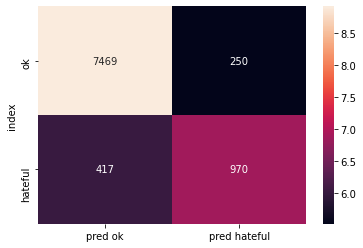

In [69]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

<AxesSubplot:ylabel='index'>

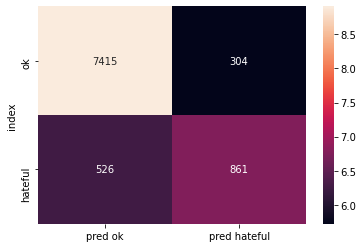

In [70]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["no_context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

## Errors

In [72]:
df["predicted"] = df["context_pred"] > 0


In [74]:
false_negatives = df.loc[((~df["predicted"]) & (df["labels"])) != 0]

false_positives = df.loc[((df["predicted"]) & (~df["labels"])) != 0]

columns = ["text", "context", "tokenized_text"] + extended_hate_categories
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [77]:
false_negatives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
349815,"[USER] Y si dejamos de comprar "" Made in china"" y se vuelven a morir de hambre como en la época de Mao?","China: Xi Jinping llamó a sus soldados a ""prepararse para la guerra""","[CLS] china : xi jinping llamó a sus soldados a "" prepararse para la guerra "" [SEP] [USER] y si dejamos de comprar "" made in china "" y se vuelven a morir de hambre como en la época de mao? [SEP]",1,0,0,1,0,0,0,0,0
404668,"[USER] Van a solo darle uso para aspirar cocaina. Una investigación analizó que los billetes de circulación que hoy tenés en tu billetera, contienen cocaina entre las fibras del papel moneda. No sólo acá, en el mundo entero.[EMOJI] hombre con la mano en la frente [EMOJI]",Senadores kirchneristas proponen que la mitad de los nuevos billetes de $1.000 tengan la cara de Maradona,"[CLS] senadores kirchneristas proponen que la mitad de los nuevos billetes de $ 1. 000 tengan la cara de maradona [SEP] [USER] van a solo darle uso para aspirar cocaina. una investigación analizó que los billetes de circulación que hoy tenés en tu billetera, contienen cocaina entre las fibras del papel moneda. no sólo acá, en el mundo entero. [EMOJI] hombre con la mano en la frente [EMOJI] [SEP]",0,0,0,0,0,0,1,0,0
356897,[USER] La resen,Río Gallegos: una mujer destruyó a palazos el auto de alta gama de su ex pareja,[CLS] río gallegos : una mujer destruyó a palazos el auto de alta gama de su ex pareja [SEP] [USER] la resen [SEP],0,1,0,0,0,0,0,0,0
337642,"[USER] Los primeros en aprender de sus errores deben ser Uds, nosotros jamás asimilamos en nuestra cultura, las atrocidades q Uds hacen con la fauna silvestre, no admitimos esos comportamientos, Uds contagiaron al mundo y hoy quieren dar consejos, primero CAMBIEN","Wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo: ""Aprendan de nuestros errores""","[CLS] wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo : "" aprendan de nuestros errores "" [SEP] [USER] los primeros en aprender de sus errores deben ser uds, nosotros jamás asimilamos en nuestra cultura, las atrocidades q uds hacen con la fauna silvestre, no admitimos esos comportamientos, uds contagiaron al mundo y hoy quieren dar consejos, primero cambien [SEP]",0,0,0,1,0,0,0,0,0
344239,[USER] Caminemos a Luján para apoyar este santo,"Coronavirus en Argentina: un dirigente radical deseó que la pandemia ""haga una limpieza étnica"" con ""negros de La Matanza""","[CLS] coronavirus en argentina : un dirigente radical deseó que la pandemia "" haga una limpieza étnica "" con "" negros de la matanza "" [SEP] [USER] caminemos a luján para apoyar este santo [SEP]",0,0,0,1,1,0,0,0,0
372322,[USER] Panzón pelotudo,Alberto Fernández le agradeció al Chacho Coudet la cerveza personalizada que le envió,[CLS] alberto fernández le agradeció al chacho coudet la cerveza personalizada que le envió [SEP] [USER] panzón pelotudo [SEP],0,0,0,0,0,0,0,1,0
393954,[USER] De sentarse en el pinocho a comer moluscos! Ni vos te la crees Duggan,"Pablo Duggan se casó con Karen, su novia venezolana: ""Estoy muy feliz de haberla conocido, me cambió la vida""","[CLS] pablo duggan se casó con karen, su novia venezolana : "" estoy muy feliz de haberla conocido, me cambió la vida "" [SEP] [USER] de sentarse en el pinocho a comer moluscos! ni vos te la crees duggan [SEP]",0,0,1,0,0,0,0,0,0
367467,[USER] Siempre los chinos metidos en cada quilombo posible ... son como langostas ...,Los pesqueros chinos están poniendo en riesgo la supervivencia de diversas especies animales en las islas Galápagos,[CLS] los pesqueros chinos están poniendo en riesgo la supervivencia de diversas especies animales en las islas galápagos [SEP] [USER] siempre los chinos metidos en cada quilombo posible... son como langostas... [SEP],0,0,0,1,0,0,0,0,0
359910,[USER] Qué pena lo tuyo pibe! Cada vez más derechoso...

In [76]:
false_positives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
370092,usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo...que conceptos equivocados tenés...,"Florencia Peña: “No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia”","[CLS] Florencia Peña : [UNK] No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia [UNK] [SEP] usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo... que conceptos equivocados tenés... [SEP]",0,0,0,0,0,0,0,0,0
404745,"usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans , es travesti.","Historia: Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans","[CLS] Historia : Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans [SEP] usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans, es travesti. [SEP]",0,0,0,0,0,0,0,0,0
339575,usuario UN CHINO NEGRO !,El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan,[CLS] El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan [SEP] usuario UN CHINO NEGRO! [SEP],0,0,0,0,0,0,0,0,0
352492,usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno.,Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía,[CLS] Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía [SEP] usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno. [SEP],0,0,0,0,0,0,0,0,0
384426,usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución . L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS.,Interna por la Villa 31: AySA apunta al Gobierno de la Ciudad por la falta de agua,[CLS] Interna por la Villa 31 : AySA apunta al Gobierno de la Ciudad por la falta de agua [SEP] usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución. L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS. [SEP],0,0,0,0,0,0,0,0,0
402742,usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA....,“Basurero de la democracia”: cómo quedó Tribunales tras el paso de la marcha por Milagro Sala,[CLS] [UNK] Basurero de la democracia [UNK] : cómo quedó Tribunales tras el paso de la marcha por Milagro Sala [SEP] usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA.... [SEP],0,0,0,0,0,0,0,0,0
400542,usuario Seguramente la queria poner,Tucumán: masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse,[CLS] Tucumán : masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse [SEP] usuario Seguramente la queria poner [SEP],0,0,0,0,0,0,0,0,0
388725,usuario Dónalo papu,"Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito: “El dinero me ha ensuciado como persona”","[CLS] Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito : [UNK] El dinero me ha ensuciado como persona [UNK] [SEP] usuario Dónalo papu [SEP]",0,0,0,0,0,0,0,0,0
341477,"usuario No son clientes, son prostituyentes!",Coronavirus: el Papa envió ayuda a transexuales que se quedaron sin clientes,"[CLS] Coronavirus : el Papa envió ayuda a transexuales que se quedaron sin clientes [SEP] usuario No son clientes, son prostituyentes! [SEP]",0,0,0,0,0,0,0,0,0


Veamos en qué categorías falla más


In [71]:
hateful = dev_df[dev_df["labels"] == 1]

std = hateful[extended_hate_categories].std()
(false_negatives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.16003
WOMEN         0.18792
LGBTI         0.07151
RACISM       -0.02460
CLASS         0.07151
POLITICS     -0.01147
DISABLED      0.03928
APPEARANCE   -0.14719
CRIMINAL     -0.17322
dtype: float64

A ver, de lo que vemos:

- Hay sustancialmente más falsos negativos sobre la categoría mujer => veamos ahí!
- Hay muy pocos de apariencia

In [72]:
(false_positives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.47331
WOMEN        -0.43051
LGBTI        -0.32420
RACISM       -0.66105
CLASS        -0.32420
POLITICS     -0.43754
DISABLED     -0.25542
APPEARANCE   -0.49147
CRIMINAL     -0.46874
dtype: float64

Con **falsos positivos** tenemos:

- 